In [1]:
# ! pip install nvidia-modulus
# !pip install importlib-metadata


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of zarr to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.8/548.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# !pip install "pint==0.19.2"
# !pip install nvidia-modulus
# !pip install nvidia-modulus-sym==1.6.0 --no-build-isolation
# !pip install torchviz

This notebook is an introduction to Physics-Informed Machine Learning

In what follows we will try to solve the ODE of the classic problem *Two Spring-Coupled Masses*, using [Nvidia Modulus library](https://docs.nvidia.com/deeplearning/modulus/getting-started/index.html)

![texte du lien](https://miro.medium.com/v2/resize:fit:1400/1*tkCUQCaE-kG9rTKavRs6bQ.png "Two Spring-Coupled Masses")

Motion Analytic equation of

$E(1):  m_1\,\ddot{x}_1$	$\displaystyle = -k_1\,x_1 +k_2\,(x_2-x_1)	$

$E(2):  m_2\,\ddot{x}_2$	$\displaystyle = -k_2\,(x_2-x_1) +k_3\,(-x_2) $

<br/>
Analytics solution



In [23]:

import os
import logging
import warnings

import numpy as np
import torch

from IPython.display import Image
import matplotlib.pyplot as plt

!python --version

Python 3.8.13


In [3]:
import modulus

from modulus.hydra import to_yaml
from modulus.hydra.utils import compose
from modulus.hydra.config import ModulusConfig

from sympy import Symbol, Function, Number, Symbol, Eq


from modulus.eq.pde import PDE
from modulus.hydra  import ModulusConfig, instantiate_arch
from modulus.solver import Solver

from modulus.domain import Domain
from modulus.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseBoundaryConstraint,
)

from modulus.geometry.primitives_1d import Point1D
from modulus.geometry import Parameterization

from modulus.domain.validator import PointwiseValidator
from modulus.key import Key
from modulus.node import Node




In [5]:
# import modulus.sym
# from modulus.sym.hydra import to_yaml
# from modulus.sym.hydra.utils import compose
# from modulus.sym.hydra.config import ModulusConfig
# from modulus.sym.models.fully_connected import FullyConnectedArch
# from modulus.sym.key import Key
# from modulus.sym.geometry.primitives_1d import Line1D
# from modulus.sym.domain import Domain
# from modulus.sym.domain.constraint import PointwiseBoundaryConstraint, PointwiseInteriorConstraint
# from modulus.sym.domain.inferencer import PointwiseInferencer
# from modulus.sym.eq.pde import PDE
# from modulus.sym.solver import Solver
# from sympy import Symbol, Number, Function
# import numpy as np
# import torch
# from torchviz import make_dot

# warnings.filterwarnings("ignore")

In [10]:
# Create config.yaml file

config_content = """
  defaults :
    - modulus_default
    - arch:
        - fully_connected
    - scheduler: tf_exponential_lr
    - optimizer: adam
    - loss: sum
    - _self_

  save_filetypes : "vtk,npz"

  scheduler:
    decay_rate: 0.95
    decay_steps: 100

  training:
    rec_results_freq: 500
    max_steps : 5000

  batch_size:
    IC: 10
    interior: 256
"""

# Write to a config.yaml file
config_file = "config.yaml"
with open(config_file, "w") as file:
    file.write(config_content)

print(f"{config_file} file created successfully!")



# Load config.yaml
cfg = compose(config_path=".", config_name="config")
cfg.network_dir = 'outputs'

config.yaml file created successfully!


In [11]:
MASS_CONST = (1, 1) # (m1, m2)
SPRING_CONST = (2, 1, 1) # (k1, k2, k3)

In [12]:

class SpringMass(PDE):
    name = "SpringMass"

    def __init__(self, k=SPRING_CONST, m=MASS_CONST):

        self.k = k
        self.m = m

        k1 = k[0]
        k2 = k[1]
        k3 = k[2]
        m1 = m[0]
        m2 = m[1]

        t = Symbol("t")
        input_variables = {"t": t}

        x1 = Function("x1")(*input_variables)
        x2 = Function("x2")(*input_variables)

        if   type(k1) is str: k1 = Function(k1)(*input_variables)
        elif type(k1) in [float, int]: k1 = Number(k1)
        else : raise Exception("k1 should be a number or a str")


        if   type(k2) is str:k2 = Function(k2)(*input_variables)
        elif type(k2) in [float, int]: k2 = Number(k2)
        else : raise Exception("k2 should be a number or a str")


        if   type(k3) is str: k3 = Function(k3)(*input_variables)
        elif type(k3) in [float, int]: k3 = Number(k3)
        else : raise Exception("k3 should be a number or a str")


        if   type(m1) is str: m1 = Function(m1)(*input_variables)
        elif type(m1) in [float, int]: m1 = Number(m1)
        else : raise Exception("m1 should be a number or a str")


        if   type(m2) is str:m2 = Function(m2)(*input_variables)
        elif type(m2) in [float, int]:m2 = Number(m2)
        else : raise Exception("m2 should be a number or a str")


        #define the equations for the two masses
        self.equations = {}
        self.equations["ode_x1"] = m1 * (x1.diff(t)).diff(t) + k1 * x1        - k2 * (x2 - x1)
        self.equations["ode_x2"] = m2 * (x2.diff(t)).diff(t) + k2 * (x2 - x1) - k3 * ( - x2)


In [20]:
# @modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig, t_max:float = 10.0, initials_xi:dict = { "x1": 1.0, "x2": 0 }) -> None:

    # make list of nodes to unroll graph on
    sm = SpringMass(k=SPRING_CONST, m=MASS_CONST)

    #define the NN arch
    sm_net = instantiate_arch(
        input_keys = [Key("t")], #we have the param t
        output_keys= [Key("x1"), Key("x2") ], #and we try to predit x1(t) and x2(t)
        cfg=cfg.arch.fully_connected, #using a fully connected NN
    )

    nodes = sm.make_nodes() + [
        sm_net.make_node(name="spring_mass_network", jit=cfg.jit)
    ]

    # add constraints to solver
    # make 1D geometry
    geo = Point1D(0)

    t_symbol = Symbol("t")
    x = Symbol("x")
    time_range = {t_symbol: (0, t_max)}

    # make domain
    domain = Domain()

    # initial conditions at t = 0 by default
    IC = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar= { **{ "x1__t": 0, "x2__t": 0, },  **initials_xi},
        batch_size=cfg.batch_size.IC,
        lambda_weighting={
            "x1": 1.0,    "x2": 1.0,
            "x1__t": 1.0, "x2__t": 1.0,
        },
        parameterization=Parameterization({t_symbol: 0}),
    )
    domain.add_constraint(IC, name="IC")

    # solve over given time period
    interior = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0, "ode_x2": 0.0, },
        batch_size=cfg.batch_size.interior,
        parameterization=Parameterization(time_range),
    )
    domain.add_constraint(interior, "interior")

    # add validation data
    deltaT = 0.001
    t = np.arange(0, t_max, deltaT)
    t = np.expand_dims(t, axis=-1)
    invar_numpy = {"t": t}
    outvar_numpy = {
        "x1": (1 / 6) * np.cos(t)
        + (1 / 2) * np.cos(np.sqrt(3) * t)
        + (1 / 3) * np.cos(2 * t),
        "x2": (2 / 6) * np.cos(t)
        + (0 / 2) * np.cos(np.sqrt(3) * t)
        - (1 / 3) * np.cos(2 * t),
    }
    validator = PointwiseValidator(
        nodes=nodes, invar=invar_numpy, true_outvar=outvar_numpy, batch_size=1024
    )
    domain.add_validator(validator)

    # make solver
    slv = Solver(cfg, domain)

    # start solver
    slv.solve()


    return None

In [21]:
run( cfg=cfg)

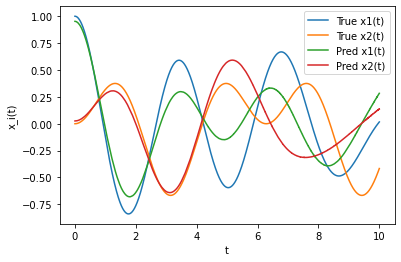

In [27]:
# Visualize the results and compare with analytical solution

def plot_res(base_dir = "./outputs/validators/"):
    # plot in 1d
    data = np.load(base_dir + "validator.npz", allow_pickle=True)
    data = np.atleast_1d(data.f.arr_0)[0]

    plt.plot(data["t"], data["true_x1"], label="True x1(t)")
    plt.plot(data["t"], data["true_x2"], label="True x2(t)")

    plt.plot(data["t"], data["pred_x1"], label="Pred x1(t)")
    plt.plot(data["t"], data["pred_x2"], label="Pred x2(t)")
    plt.legend()
    plt.xlabel("t")
    plt.ylabel("x_i(t)")
    plt.show()


plot_res(base_dir = "outputs/validators/")